In [1]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import nest
import itertools


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-3.0
 Built: Sep  5 2022 01:11:55

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



# Introduction
In order to understand the inner workings of neuronal circuits, one ansatz is to build and study computer models of such circuits. In those models we try to create carefully designed reduced models of complex structures, taking into account only what we believe is important to address a certain scientific question. If the reduced model is able to reproduce certain properties of the more complex system, one can hope that analyzing the model further might reveal answers to those questions or generate hypothesis which then can be experimentally tested.
In this introductory part of the NEST project we will investigate a basic model of a cortical circuit. But in order to assess whether the model reasonably reproduces dynamical features of cortical circuits, we need to know how the dynamics in those circuits looks like.
</br>
## Raster plot and instantaneous rate
Given spike trains taken from the observed data of an experimental setups, the first thing one often considers are the spike raster plot and the instantaneous firing rate of the populations.
<img src="images/raster.jpeg" width="600" align="center">
<caption>Spike raster plot of neuronal population in visual cortex of awake mice. Lower parts shows temporal histogram of the spontaneous activity. Figure taken from <a href="https://www.jneurosci.org/content/35/23/8813"> Carrillo-Reid et al. 2015, Journal of Neuroscience. </a><caption>

   
Recording multiple trials from a single neuron, one may also consider the spike raster plots over trials.
<img src="images/raster_2.jpeg" width="500" align="center">
<caption>Raster plot and firing rate of MT neuron in multiple trials given different stimulus parameters. Taken from Dayan and Abbot, Theoretical Neuroscience, p. 39<caption>
    
## Insterspike interval distribution
One commonly also studies the interspike interval (ISI) distribution of neural firing.
</br>
<img src="images/isi.jpeg" width="350" align="center">
<caption> Interspike interval distribution from an MT neuron. Taken from Dayan and Abbot, Theoretical Neuroscience, p. 33 <caption>
    
## Correlation histograms
Finally, we consider auto- and cross-correlation histograms. These are studied to study correlations and synchrony in neural systems under a (variable) time delay.
<img src="images/correlations.jpeg" width="400" align="center">
<caption>Auto- and cross-correlation function for neurons in cat V1. Oscillations are induced via a specific stimulus. Taken from Dayan and Abott, Theoretical Neuroscience, p. 29<caption>
 <img src="images/correlations_2.jpeg" width="400" align="center">   
 <caption>Cross-correlations of several pairs of hippocampus CA1 neurons. The arrows indicate putative connections inferred from the correlation function. Figure taken from <a href="https://www.nature.com/articles/s41467-019-12225-2">Kobayashi et al. 2019, Nature Communications </a><caption>

# NEST - Getting started
## The Brunel network

To learn the basic functionalities of NEST and get a feeling which type question we might address with spiking neural network simulations, we will implement the [Brunel network](https://link.springer.com/article/10.1023/A:1008925309027).
<!-- (https://web.stanford.edu/group/brainsinsilicon/documents/BrunelSparselyConnectedNets.pdf).   -->
</br>
It's a sparse random network consisting of $N$ leaky integrate-and-fire model neuron $N_E$ of which are excitatory and $N_I$ inhibitory. Each neuron receives $C$ randomly chosen connections of which $C_E = \epsilon N_E$ are excitatory and $C_I = \epsilon N_I$ are inhibitory. The coupling strength for excitatory connections is $J$, for inhibitory connections it is $-g\cdot J$. Each neuron in the network is provided with an excitatory Poissonian background spike train whose strength is measured in 
\begin{equation}
    \eta = \frac{\eta_{\mathrm{ext}}}{\eta_{\mathrm{thr}}}.
\end{equation}
Here, $\eta_{\mathrm{thr}}$ denotes the rate at which the average membrane potential of a neuron provided with a Poissonian background spike train reaches the threshold.
</br>
Setting $\gamma = 0.25$, $\rho = 0.2$, typical parameter choices are:
</br>
$N = 10000$, $N_I = \rho \cdot N$, $N_E = (1 - \rho) \cdot N$, $\epsilon = 0.1$, $g = 4$, $\eta = 2\frac{\mathrm{spikes}}{\mathrm{s}}$.
</br>
A suitable size of $J$ depends on the parameters of the model neurons, but it is important that $g \geq 4$.
Otherwise we expect - without going into much detail - that the average input of a neuron in the network to be proportional to
\begin{equation}
    C_E\cdot J - C_I \cdot g \cdot J = \epsilon \cdot N \cdot J \cdot \big( (1-\rho) - g \cdot \rho \big)
\end{equation}
If this quantity is positive, the dynamics of the network will result in a positive feedback loop leading to exploding / runaway activity in the network.
</br>
Therefore, for the network to be in a low firing-rate regime - the following relation should hold true:
\begin{equation}
    (1-\rho) - g \cdot \rho \leq 0.
\end{equation}
Solving for $g$ with $\rho = 0.2$ yields the aforementioned constraint.

In [2]:
# Network parameters
neuron_params = {"C_m": 1.0,
                 "tau_m": 20.,
                 "t_ref": 2.0,
                 "E_L": 0.0,
                 "V_reset": 0.0,
                 "V_m": 0.0,
                 "V_th": 20.}

params = {
    'num_neurons': 12500,  # number of neurons in network
    'rho': 0.2, # fraction of inhibitory neurons
    'eps': 0.1, # probability to establish a connections
    'g': 4.5,  # excitation-inhibition balance
    'eta': 0.9,  # relative external rate
    'J': 0.1,  # postsynaptic amplitude in mV
    'neuron_params': neuron_params,  # single neuron parameters
    'n_rec_ex': 400,  # excitatory neurons to be recorded from
    'n_rec_in': 100,  # inhibitory neurons to be recorded from
    'rec_start': 600.,  # start point for recording spike trains
    'rec_stop': 800.  # end points for recording spike trains
}

We now implement the Brunel network. Instead of doing it straightforwardly, we will do it in a Python class.
</br>
Though it might seem unnecessary at the moment, it will turn out to be convenient later.

In [3]:
class BrunelNetwork:
    def __init__(self, num_neurons, rho, eps, g, eta, J, neuron_params, n_rec_ex, n_rec_in, rec_start, rec_stop):
        self.num_neurons = num_neurons
        self.num_ex = int((1 - rho) * num_neurons)  # number of excitatory neurons
        self.num_in = int(rho * num_neurons)  # number of inhibitory neurons
        self.c_ex = int(eps * self.num_ex)  # number of excitatory connections
        self.c_in = int(eps * self.num_in)  # number of inhibitory connections
        self.J_ex = J  # excitatory weight
        self.J_in = -g*J  # inhibitory weight
        self.n_rec_ex = n_rec_ex # number of recorded excitatory neurons, both excitatory and inhibitory
        self.n_rec_in = n_rec_in # number of recorded excitatory neurons, both excitatory and inhibitory
        self.rec_start = rec_start
        self.rec_stop = rec_stop
        self.neuron_params = neuron_params  # neuron params
        self.ext_rate = (self.neuron_params['V_th'] 
                         / (J * self.c_ex * self.neuron_params['tau_m'])
                         * eta * 1000. * self.c_ex)
        
    def create(self):
        # Create the network
        
        # First create the neurons
        self.neurons_ex = nest.Create('iaf_psc_delta', self.num_ex, params=self.neuron_params)
        self.neurons_in = nest.Create('iaf_psc_delta', self.num_in, params=self.neuron_params)
        
        self.neurons = self.neurons_ex + self.neurons_in
        
        # Then create the external spike generator
        self.poisson_noise = nest.Create('poisson_generator', params={'rate': self.ext_rate})
        
        # Then create spike detectors
        self.detector_ex = nest.Create('spike_recorder',
                                       self.n_rec_ex,
                                       params={'start' : self.rec_start, 'stop': self.rec_stop})
        self.detector_in = nest.Create('spike_recorder',
                                       self.n_rec_in,
                                       params={'start': self.rec_start, 'stop': self.rec_stop})
        
        
        # Next we connect the neurons
        nest.Connect(self.neurons_ex, self.neurons_ex,
                     conn_spec = {'rule': 'fixed_indegree',
                                 'indegree': self.c_ex},
                     syn_spec = {'synapse_model': 'static_synapse',
                                 'delay': 1.5,
                                 'weight': self.J_ex})
        nest.Connect(self.neurons_ex, self.neurons_in,
                     conn_spec = {'rule': 'fixed_indegree',
                                 'indegree': self.c_ex},
                     syn_spec = {'synapse_model': 'static_synapse',
                                 'delay': 1.5,
                                 'weight': self.J_ex})
        
        
        nest.Connect(self.neurons_in, self.neurons,
                     conn_spec = {'rule': 'fixed_indegree',
                                 'indegree': self.c_in},
                     syn_spec = {'synapse_model': 'static_synapse',
                                 'delay': 1.5,
                                 'weight': self.J_in})
        
        # Then we connect the external drive to the neurons
        nest.Connect(self.poisson_noise, self.neurons,
                     syn_spec = {'synapse_model': 'static_synapse',
                                 'delay': 1.5,
                                 'weight': self.J_ex})
        
        # Then we connect the the neurons to the spike detectors
        nest.Connect(self.neurons_ex[:self.n_rec_ex], self.detector_ex, 'one_to_one')
        nest.Connect(self.neurons_in[:self.n_rec_in], self.detector_in, 'one_to_one')
        
    def simulate(self, t_sim):
        # Simulate the network with specified 
        nest.Simulate(t_sim)
        
    def get_data(self):
        # get spikes from recorders
        spikes_ex = []
        spikes_in = []
        
        for i in range(self.n_rec_ex):
            spikes_ex.append(
                list(np.sort(nest.GetStatus(self.detector_ex)[i]['events']['times'])))
        for i in range(self.n_rec_in):
            spikes_in.append(
                list(np.sort(nest.GetStatus(self.detector_in)[i]['events']['times'])))
            
        return spikes_ex, spikes_in
        

In [4]:
# Helper function to plot spiking activity
def plot_raster_rate(spikes_ex, spikes_in, rec_start, rec_stop, figsize=(9, 5)):
    
    spikes_ex_total = list(itertools.chain(*spikes_ex))
    spikes_in_total = list(itertools.chain(*spikes_in))
    spikes_total = spikes_ex_total + spikes_in_total
    
    n_rec_ex = len(spikes_ex)
    n_rec_in = len(spikes_in)
    
    fig = plt.figure(constrained_layout=True, figsize=figsize)
    gs = fig.add_gridspec(5, 1)
    
    ax1 = fig.add_subplot(gs[:4,0])
    ax2 = fig.add_subplot(gs[4,0])
    
    ax1.set_xlim([rec_start, rec_stop])
    ax2.set_xlim([rec_start, rec_stop])
    
    ax1.set_ylabel('Neuron ID')
    
    ax2.set_ylabel('Firing rate')
    ax2.set_xlabel('Time [ms]')
    
    
    for i in range(n_rec_in):
        ax1.plot(spikes_in[i],
                 i*np.ones(len(spikes_in[i])),
                 linestyle='',
                 marker='o',
                 color='r',
                 markersize=2)
    for i in range(n_rec_ex):
        ax1.plot(spikes_ex[i],
                 (i + n_rec_in)*np.ones(len(spikes_ex[i])),
                 linestyle='',
                 marker='o',
                 color='b',
                 markersize=2)

        
    ax2 = ax2.hist(spikes_ex_total,
                   range=(rec_start,rec_stop),
                   bins=int(rec_stop - rec_start))

    plt.savefig('raster.png')

    time_diff = (rec_stop - rec_start)/1000.
    average_firing_rate = (len(spikes_total)
                           / time_diff
                           /(n_rec_ex + n_rec_in))
    print(f'Average firing rate: {average_firing_rate} Bq')
    

After having implemented the Brunel network we will investigate it's dynamical states.
</br>
As it turns out, the network mainly does exhibit four different dynamical states (c.f. figure 8 from paper):
* a fast oscillatory state with high firing rates and synchronous activity (panel A)
* a fast oscillatory state with lower firing rates and asynchronous activity (panel B)
* a asynchronous and irregular state (panel C)
* a slow oscillatory state with irregular activity (panel D)

## Task
Reproduce Figure 8 from the paper and explore the different dynamical regimes - don't think to much about the presentation.

# Fast oscillations, high firing rates and synchronous regular activity


Sep 05 11:31:26 NodeManager::prepare_nodes [Info]: 
    Preparing 14504 nodes for simulation.

Sep 05 11:31:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 14504
    Simulation time (ms): 820
    Number of OpenMP threads: 4
    Not using MPI

Sep 05 11:32:01 SimulationManager::run [Info]: 
    Simulation finished.
Average firing rate: 192.61 Bq


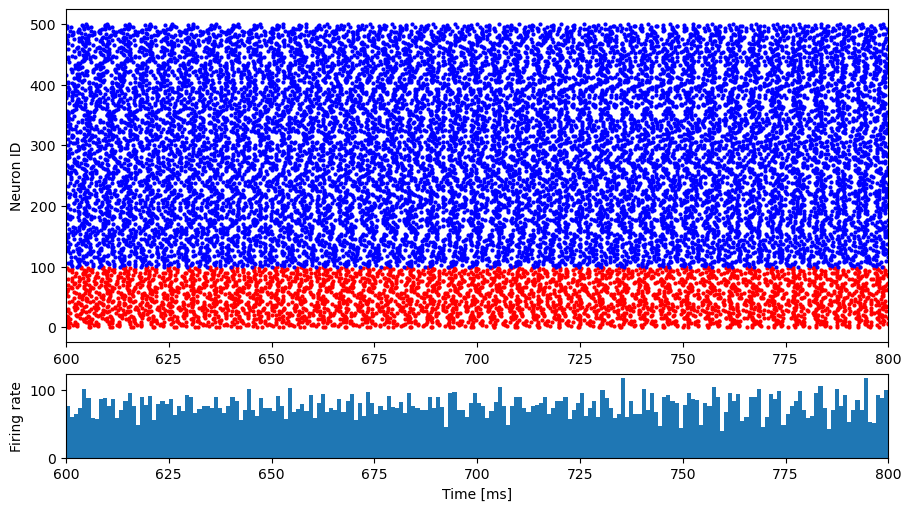

In [5]:
nest.ResetKernel()
nest.SetKernelStatus({'local_num_threads': 4})
params['g'] = 3.
params['eta'] = 2.
params['J'] = 0.1
params['rec_start'] = 600.
params['rec_stop'] = 800.

network = BrunelNetwork(**params)

network.create()
network.simulate(820.)
spikes_ex, spikes_in = network.get_data()
plot_raster_rate(spikes_ex, spikes_in, params['rec_start'], params['rec_stop'])

# Fast oscillations, lower firing rates and irregular activity


Sep 05 11:32:07 NodeManager::prepare_nodes [Info]: 
    Preparing 14504 nodes for simulation.

Sep 05 11:32:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 14504
    Simulation time (ms): 820
    Number of OpenMP threads: 4
    Not using MPI

Sep 05 11:32:25 SimulationManager::run [Info]: 
    Simulation finished.
Average firing rate: 49.48 Bq


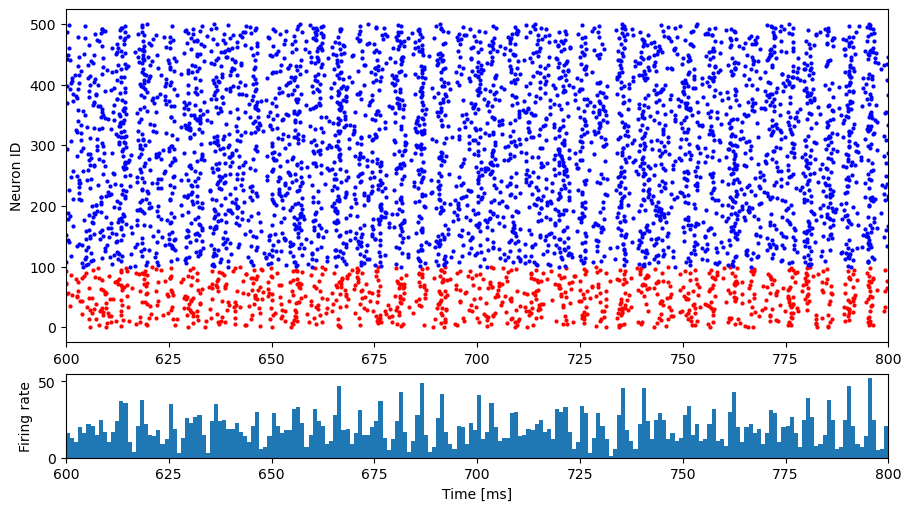

In [6]:
nest.ResetKernel()
nest.SetKernelStatus({'local_num_threads': 4})
params['g'] = 6.
params['eta'] = 4.
params['J'] = 0.1
params['rec_start'] = 600.
params['rec_stop'] = 800.

network = BrunelNetwork(**params)

network.create()
network.simulate(820.)
spikes_ex, spikes_in = network.get_data()
plot_raster_rate(spikes_ex, spikes_in, params['rec_start'], params['rec_stop'])

# Asynchronous and irregular state


Sep 05 11:32:32 NodeManager::prepare_nodes [Info]: 
    Preparing 14504 nodes for simulation.

Sep 05 11:32:33 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 14504
    Simulation time (ms): 820
    Number of OpenMP threads: 4
    Not using MPI

Sep 05 11:32:44 SimulationManager::run [Info]: 
    Simulation finished.
Average firing rate: 32.12 Bq


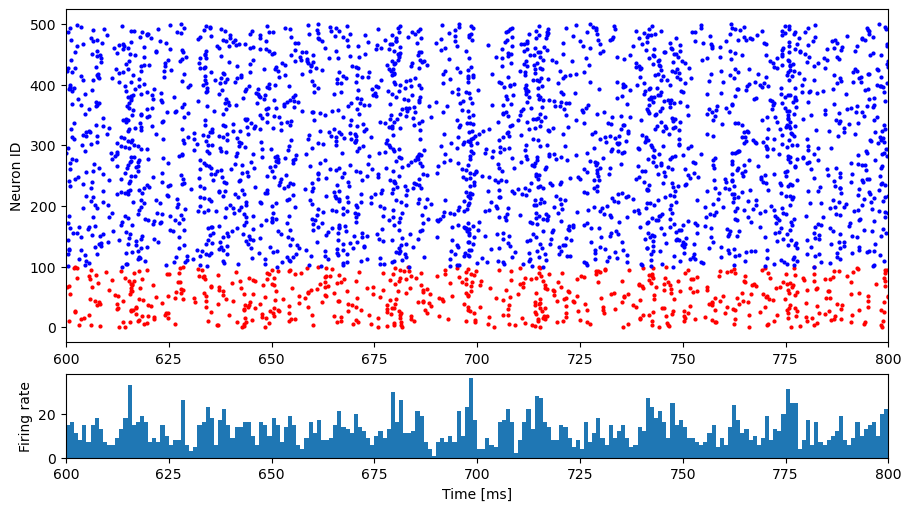

In [7]:
nest.ResetKernel()
nest.SetKernelStatus({'local_num_threads': 4})
params['g'] = 5.
params['eta'] = 2
params['J'] = 0.1
params['rec_start'] = 600.
params['rec_stop'] = 800.

network = BrunelNetwork(**params)

network.create()
network.simulate(820.)
spikes_ex, spikes_in = network.get_data()
plot_raster_rate(spikes_ex, spikes_in, params['rec_start'], params['rec_stop'])

# Slow oscillations and irregular activity


Sep 05 11:32:50 NodeManager::prepare_nodes [Info]: 
    Preparing 14504 nodes for simulation.

Sep 05 11:32:51 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 14504
    Simulation time (ms): 820
    Number of OpenMP threads: 4
    Not using MPI

Sep 05 11:32:55 SimulationManager::run [Info]: 
    Simulation finished.
Average firing rate: 3.6 Bq


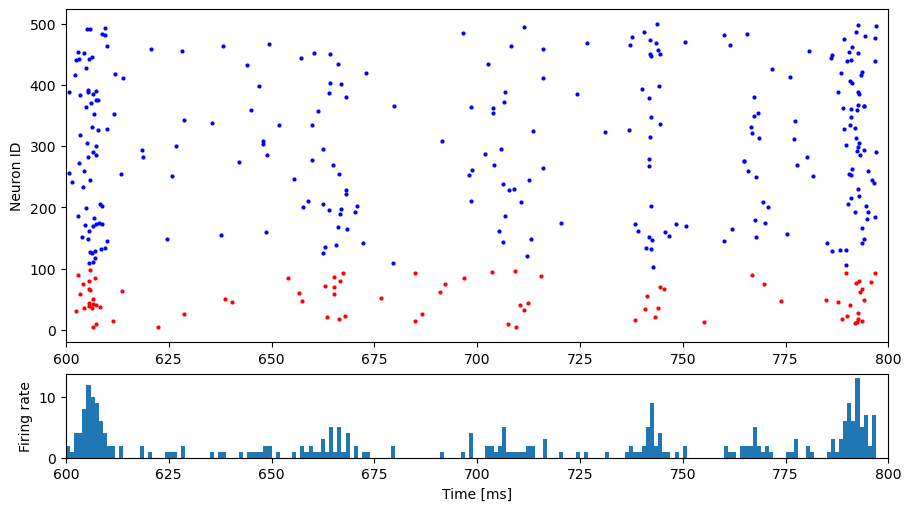

In [8]:
nest.ResetKernel()
nest.SetKernelStatus({'local_num_threads': 4})
params['g'] = 5
params['eta'] = 0.9
params['J'] = 0.1
params['rec_start'] = 600.
params['rec_stop'] = 800.

network = BrunelNetwork(**params)

network.create()
network.simulate(820.)
spikes_ex, spikes_in = network.get_data()
plot_raster_rate(spikes_ex, spikes_in, params['rec_start'], params['rec_stop'])

So far, we only have changed the relative external rate $\eta$ as well as the excitation-inhibition balance $g$.
</br>
In the example below we change the EPSP $J$ to induce a more synchronous state in the network.
</br> 
But there are also other parameters to tweak! Up to now, we assumed a constant delay. However, in biology the delay is not constant but rather mediated. Which effect does a wide delay distribution have on the network dynamics?


Sep 05 11:33:02 NodeManager::prepare_nodes [Info]: 
    Preparing 14504 nodes for simulation.

Sep 05 11:33:03 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 14504
    Simulation time (ms): 820
    Number of OpenMP threads: 4
    Not using MPI

Sep 05 11:33:08 SimulationManager::run [Info]: 
    Simulation finished.
Average firing rate: 5.75 Bq


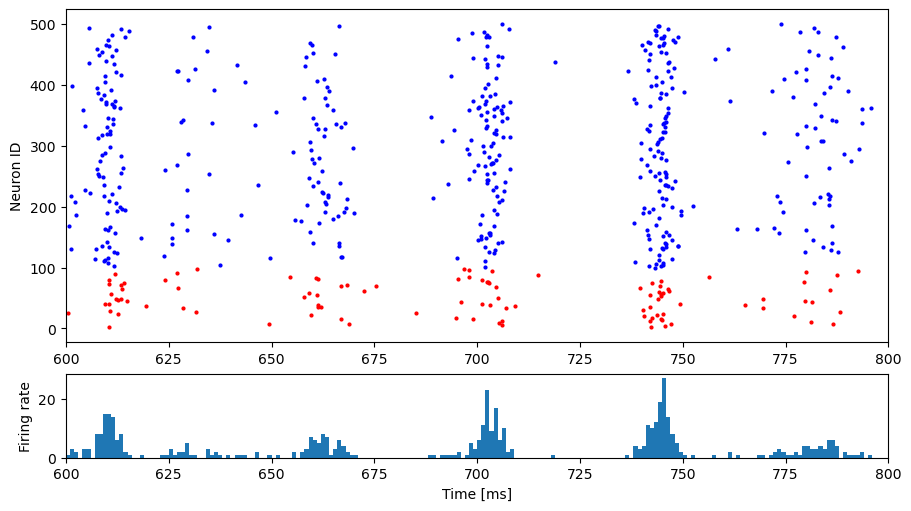

In [9]:
nest.ResetKernel()
nest.SetKernelStatus({'local_num_threads': 4})
params['g'] = 4.5
params['eta'] = 0.9
params['J'] = 0.1
params['rec_start'] = 600.
params['rec_stop'] = 800.

network = BrunelNetwork(**params)

network.create()
network.simulate(820.)
spikes_ex, spikes_in = network.get_data()
plot_raster_rate(spikes_ex, spikes_in, params['rec_start'], params['rec_stop'])

# Spike train statistics
After we got a first glance at the produced spiking data, we will continue investigating the obtained acitivty. We next turn to the inter-spike interval (ISI).
</br>
Two quantities studied most frequently in this context are the ISI distribution (i.e. the probability distribution function of the inter-spike interval) and the coefficient of variation (CV).
</br>
The latter one is defined as
\begin{equation}
    \mathrm{CV} = \frac{\sigma}{\mu}
\end{equation}
where $\mu$ denotes mean and $\sigma$ the standard deviation of the spike train. The CV is a measure for the regularity of the spike train:
* a small CV << 1 implies that relative to the mean the standard deviation is small --> regular firing
* a large CV >> 1 implies that relative to the mean the standard deviation is large --> bursty behaviour
* a CV ~ 1 implies irregular firing

As a matter of fact, the CV of an [exponential ISI distribution](https://en.wikipedia.org/wiki/Exponential_distribution) equals $1$. This is often a basic model for neuronal firing.
</br>
And indeed, due to the memorylesness property of an exponential distribution, i.e. for an exponentially distributed $T$ we have
\begin{equation}
    \mathbb{P}[T> s+t | T > t] = \mathbb{P}[T > s],
\end{equation}
then a spike train with exponentially distributed ISIs is "the most random" possible, since no matter how long one already waited for the next spike, the probability of a spike occuring in the next time interval is independent of that waited time.

In [5]:
def single_isi(spike_train, min_val, max_val, num_bins):
    
    spike_train = np.array(spike_train)
    isis = spike_train[1:] - spike_train[:-1]
    hist, bins = np.histogram(isis,
             range=(min_val, max_val),
             bins=num_bins,
             density=True)
    
    centered_bins = (bins[1:] + bins[:-1])/2 
    
    print(f'Mean of ISI: {isis.mean()}' )
    print(f'Standard deviation of ISI: {isis.std()}' )
    print(f'Coefficient of variation: {isis.std()/isis.mean()}')
    
    plt.figure(figsize=(4,4))
    plt.plot(bins[1:], hist)
    
    
def average_isi(spike_trains, min_val, max_val, num_bins):
    
    means = []
    stds = []
    hists = []
    
    for i, spike_train in enumerate(spike_trains):
        
        if len(spike_train) < 1:
            continue
        
        spike_train = np.array(spike_train)
        isis = spike_train[1:] - spike_train[:-1]

        hist, bins = np.histogram(isis,
                                  range=(min_val, max_val),
                                  bins=num_bins,
                                  density=True)

        hists.append(hist)    
        means.append(isis.mean())
        stds.append(isis.std())
    
    hist = np.array(hists)
    average_hist = hist.mean(axis=0)
    means = np.array(means)
    stds = np.array(stds)
    
    print(f'Average mean of ISI: {means.mean()}')
    print(f'Average std of ISI: {stds.mean()}')
    print(f'Average CV of ISI: {stds.mean()/means.mean()}')
        
    
    centered_bins = (bins[1:] + bins[:-1])/2
    
    plt.figure(figsize=(4,4))
    plt.plot(bins[1:], average_hist)

In [11]:
# Lets initiliaze the network in the highly oscillatory, regular state
nest.ResetKernel()
nest.SetKernelStatus({'local_num_threads': 4})
params['g'] = 3
params['eta'] = 0.9
params['J'] = 0.1
params['rec_start'] = 100.
params['rec_stop'] = 1000.

network = BrunelNetwork(**params)

network.create()
network.simulate(1000.)
spikes_ex, spikes_in = network.get_data()


Sep 05 11:33:15 NodeManager::prepare_nodes [Info]: 
    Preparing 14504 nodes for simulation.

Sep 05 11:33:16 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 14504
    Simulation time (ms): 1000
    Number of OpenMP threads: 4
    Not using MPI

Sep 05 11:33:47 SimulationManager::run [Info]: 
    Simulation finished.


Mean of ISI: 7.4638655462184875
Standard deviation of ISI: 0.44527983693704776
Coefficient of variation: 0.05965807317665918


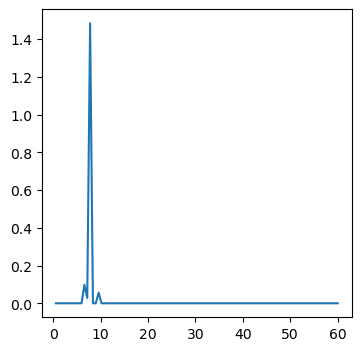

In [12]:
# Look at single ISI distribution first
single_isi(spikes_ex[100], min_val=0., max_val=60, num_bins=100)

Average mean of ISI: 7.507244487751641
Average std of ISI: 0.37779367447067586
Average CV of ISI: 0.050323880497972436


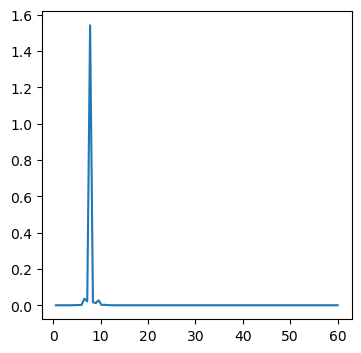

In [13]:
# Next we look at the average ISI distribution
average_isi(spikes_ex, min_val=0., max_val=60, num_bins=100)

We see that the mean of the ISI distribution is much larger than its standard deviation hinting that the activity is of the single neurons is very regular.
</br>
Next we turn to a network configuration that shows irregular activity.

In [37]:
# Let's initiliaze the network in the highly oscillatory, synchronous state
nest.ResetKernel()
nest.SetKernelStatus({'local_num_threads': 4})
params['g'] = 5
params['eta'] = 1.2
params['J'] = 0.1
params['rec_start'] = 100.
params['rec_stop'] = 1000.

network = BrunelNetwork(**params)

network.create()
network.simulate(1000.)
spikes_ex, spikes_in = network.get_data()


Sep 05 14:16:31 NodeManager::prepare_nodes [Info]: 
    Preparing 14504 nodes for simulation.

Sep 05 14:16:32 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 14504
    Simulation time (ms): 1000
    Number of OpenMP threads: 4
    Not using MPI

Sep 05 14:16:40 SimulationManager::run [Info]: 
    Simulation finished.


Mean of ISI: 70.21818181818183
Standard deviation of ISI: 11.135268962895898
Coefficient of variation: 0.1585809924803921


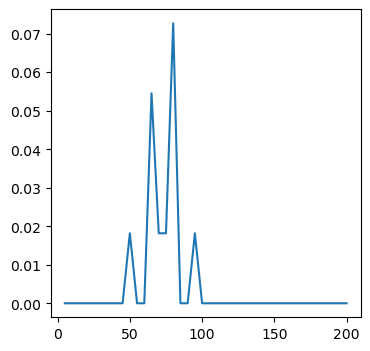

In [40]:
# Look at single ISI distribution first
single_isi(spikes_ex[2], min_val=0., max_val=200, num_bins=40)

Average mean of ISI: 77.88330572413697
Average std of ISI: 25.85173721082663
Average CV of ISI: 0.3319291210159158


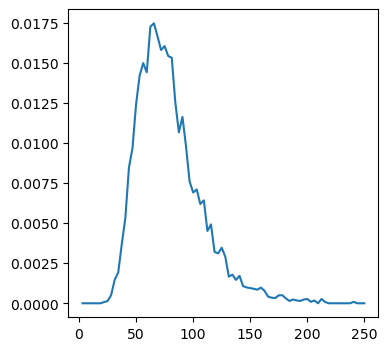

In [41]:
# Next we look at the average ISI distribution
average_isi(spikes_ex, min_val=0., max_val=250, num_bins=80)

The CV now is substantially higher from which we can conclude that the activity is much more irregular.
</br>
Finally we note that global oscillations in the activity do not necessarily translate in regular activity at the single neuron level.

In [17]:
# Using larger weights, initiliaze the network in the slow global oscillatory regime @zbarni
nest.ResetKernel()
nest.SetKernelStatus({'local_num_threads': 4})
params['g'] = 4.5
params['eta'] = 0.9
params['J'] = 0.5
params['rec_start'] = 100.
params['rec_stop'] = 2000.

network = BrunelNetwork(**params)

network.create()
network.simulate(2000.)
spikes_ex, spikes_in = network.get_data()


Sep 05 11:34:09 NodeManager::prepare_nodes [Info]: 
    Preparing 14504 nodes for simulation.

Sep 05 11:34:10 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 14504
    Simulation time (ms): 2000
    Number of OpenMP threads: 4
    Not using MPI

Sep 05 11:34:23 SimulationManager::run [Info]: 
    Simulation finished.


Mean of ISI: 56.35333333333333
Standard deviation of ISI: 39.570988811951054
Coefficient of variation: 0.7021942886303867


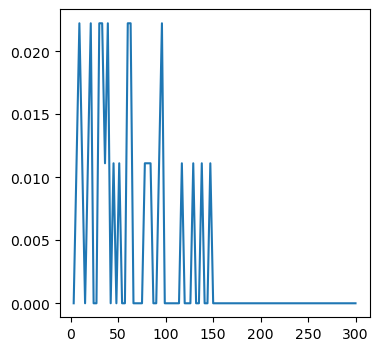

In [18]:
# Look at single ISI distribution first
single_isi(spikes_ex[100], min_val=0., max_val=300, num_bins=100)

Average mean of ISI: 86.25015942892809
Average std of ISI: 76.91983798140569
Average CV of ISI: 0.8918225599894598


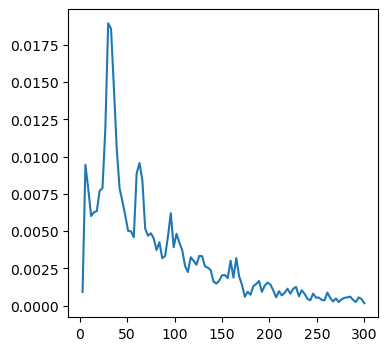

In [19]:
# Next we look at the average ISI distribution
average_isi(spikes_ex, min_val=0., max_val=300, num_bins=100)

# Time resolved correlations
After having studied the rater plot, the firing rate as well as properties of the ISI, we will turn to another tool with which we can study network dynamics: The **correlation functions**.
</br>
Given two neurons $i,j$ we consider their spike trains
\begin{equation}
    \xi_i (t) = \sum_{k} \delta(t-t^{f} _ {i,k}), \quad \xi_j (t) = \sum_{k} \delta(t-t^{f} _ {j,k}).
\end{equation}
Here, $\delta$ denotes the Dirac distribution, $t^{f} _ {i,k}$ the $k$-th spike time of the neuron $i$.
</br>
Given the spike trains as well as a bin-width $h$ we can define the spike count of neuron $i$ as 
\begin{equation}
    x_{i} ^ {h}(t) = \int_{t} ^ {t + h}\mathrm{d}s \: \xi_i (s)
\end{equation}
and similarly for neuron $j$.
</br>
Writing $\langle \rangle$ for the expected value, we define the correlation functions as
\begin{equation}
    c_{ij}(\tau) = \langle x_{i} ^ {h}(t) x_{j} ^ {h}(t+\tau) \rangle.
\end{equation}
Luckily, the spike count correlations function can be calculated by a NEST object, see [here](https://nest-simulator.readthedocs.io/en/v3.0/models/correlomatrix_detector.html?highlight=correlomatrix).

**Task**: Add the ```correlomatrix_detector``` to the network and obtain the spike count covariance.

In [6]:
class BrunelNetwork(BrunelNetwork):
    
    def correlomatrix(self, n_rec_corr_ex=10,
                      n_rec_corr_in=10,
                      delta_tau_rel=5,
                      tau_max=40.,
                      t_start=300.,
                      t_rec_corr=2300.):
        '''
        Method to create and initialize a correlomatrix_detector.
        '''
        self.n_rec_corr_ex = n_rec_corr_ex
        self.n_rec_corr_in = n_rec_corr_in
        self.n_rec_corr = self.n_rec_corr_ex + self.n_rec_corr_in
        self.dt = nest.GetKernelStatus()['resolution']
        self.delta_tau_rel = delta_tau_rel
        self.tau_max = tau_max
        self.t_start = t_start
        self.t_rec_corr = t_rec_corr
        self.correlo = nest.Create('correlomatrix_detector')
        
        nest.SetStatus(self.correlo, [{'N_channels': self.n_rec_corr,
                                       'delta_tau':  self.delta_tau_rel*self.dt,
                                       'tau_max':    self.tau_max, 
                                       'Tstart':     t_start, 
                                       'Tstop':      t_start + t_rec_corr}])
        
        for i in range(self.n_rec_corr):
            if i < self.n_rec_corr_ex:
                nest.Connect(self.neurons_ex[i], self.correlo, syn_spec={'receptor_type': i})
            else:
                i_ = i - self.n_rec_corr_ex
                nest.Connect(self.neurons_in[i_], self.correlo, syn_spec={'receptor_type': i})
            
    def get_correlomatrix(self):
        '''
        Method to 
        '''
        
        cc = np.array(nest.GetStatus(self.correlo)[0]['count_covariance'])
        cc = 1.*cc/(self.t_rec_corr*1e-3)/(self.dt*1e-3)
        
        # stack negative and positive part
        cc2 = np.zeros((self.n_rec_corr, self.n_rec_corr,2*cc.shape[2]-1))
        for i in range(self.n_rec_corr):
            for j in range(self.n_rec_corr):
                cc2[i,j,:]= np.hstack([cc[j,i,::-1],cc[i,j][1:]])
                
        n_spikes = nest.GetStatus(self.correlo)[0]['n_events']
                
        times = np.arange(-1*self.tau_max, self.tau_max + 5*self.dt, 5*self.dt)
                
        return times, cc2, n_spikes

In [7]:
def average_cc(times, cc, n_rec_corr_ex=10, n_rec_corr_in=10, figsize=(15, 15)):
    '''
    Method to average ee, ie, ei, and ii correlations functions and plot them
    
    Parameters
    ----------
    times : np.ndarray
        time array over which cc is computed
    cc : np.ndarray
        count covariance function returned from nest
    '''
    n_rec_corr = n_rec_corr_ex + n_rec_corr_in
        
    c_ee = np.zeros(np.shape(cc[0, 0]))
    c_ei = np.zeros(np.shape(cc[0, 0]))
    c_ie = np.zeros(np.shape(cc[0, 0]))
    c_ii = np.zeros(np.shape(cc[0, 0]))
    
    for i in range(n_rec_corr):
        for j in range(n_rec_corr):
            if i < n_rec_corr_ex and j < n_rec_corr_ex:
                c_ee += cc[i, j]
            elif i < n_rec_corr_ex and j > n_rec_corr_ex:
                c_ei += cc[i, j]
            elif i > n_rec_corr_ex and j < n_rec_corr_ex:
                c_ie += cc[i, j]
            elif i > n_rec_corr_ex and j > n_rec_corr_ex:
                 c_ii += cc[i, j]
                    
    c_ee /= n_rec_corr_ex**2
    c_ei /= n_rec_corr_ex*n_rec_corr_in
    c_ie /= n_rec_corr_ex*n_rec_corr_in
    c_ii /= n_rec_corr_in**2
                    
    fig = plt.figure(constrained_layout=True, figsize=figsize)
    gs = fig.add_gridspec(4, 4)
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])

    
    ax1.plot(times, c_ee, label='C_ee')
    ax1.legend()
    ax2.plot(times, c_ei, label='C_ei')
    ax2.legend()
    ax3.plot(times, c_ie, label='C_ie')
    ax3.legend()
    ax4.plot(times, c_ii, label='C_ii')
    ax4.legend()
 

Next, we want to study the correlations functions for the Brunel network in different states.
</br>
Interesting to look at could be
* the asynchronous irregular state  
* the slow oscillatory state  

How do the correlation functions differ? How does the correlation functions look for very short times? What does this imply?

In [9]:
nest.ResetKernel()
nest.SetKernelStatus({'local_num_threads': 4})
params['g'] = 5.
params['eta'] = 2.
params['J'] = 0.1

n_rec_corr_ex = 100
n_rec_corr_in = 100
t_start = 300.
t_rec_corr = 4000.
tau_max = 60.

network = BrunelNetwork(**params)

network.create()
network.correlomatrix(n_rec_corr_ex=n_rec_corr_ex,
                      n_rec_corr_in=n_rec_corr_in,
                      tau_max=tau_max,
                      t_start=t_start,
                      t_rec_corr=t_rec_corr)

network.simulate(4600.)
# times, cc, n_spikes = network.get_correlomatrix()


Sep 05 19:45:15 NodeManager::prepare_nodes [Info]: 
    Preparing 14505 nodes for simulation.

Sep 05 19:45:16 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 14505
    Simulation time (ms): 4600
    Number of OpenMP threads: 4
    Number of MPI processes: 1

Sep 05 19:46:01 SimulationManager::run [Info]: 
    Simulation finished.


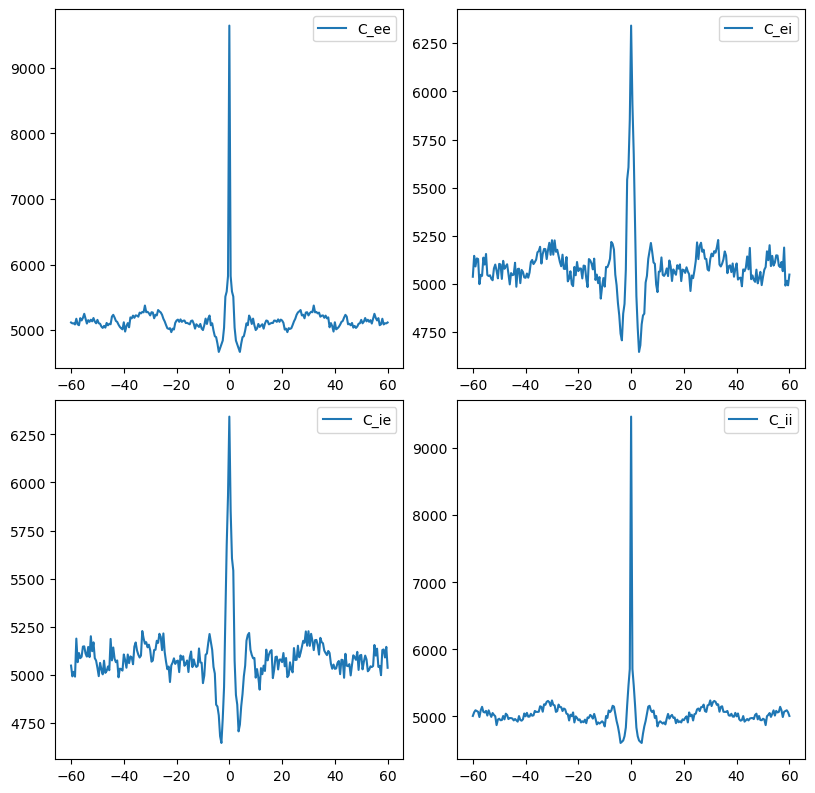

In [23]:
average_cc(times, cc, n_rec_corr_ex=n_rec_corr_ex, n_rec_corr_in=n_rec_corr_in)

In [24]:
nest.ResetKernel()
nest.SetKernelStatus({'local_num_threads': 4})
params['g'] = 5
params['eta'] = 0.9
params['J'] = 0.1

n_rec_corr_ex = 100
n_rec_corr_in = 100
t_start = 300.
t_rec_corr = 4000.
tau_max = 60.

network = BrunelNetwork(**params)

network.create()
network.correlomatrix(n_rec_corr_ex=n_rec_corr_ex,
                      n_rec_corr_in=n_rec_corr_in,
                      tau_max=tau_max,
                      t_start=t_start,
                      t_rec_corr=t_rec_corr)

network.simulate(4600.)
times, cc, n_spikes = network.get_correlomatrix()


Sep 05 11:35:38 NodeManager::prepare_nodes [Info]: 
    Preparing 14505 nodes for simulation.

Sep 05 11:35:39 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 14505
    Simulation time (ms): 4600
    Number of OpenMP threads: 4
    Not using MPI

Sep 05 11:36:03 SimulationManager::run [Info]: 
    Simulation finished.


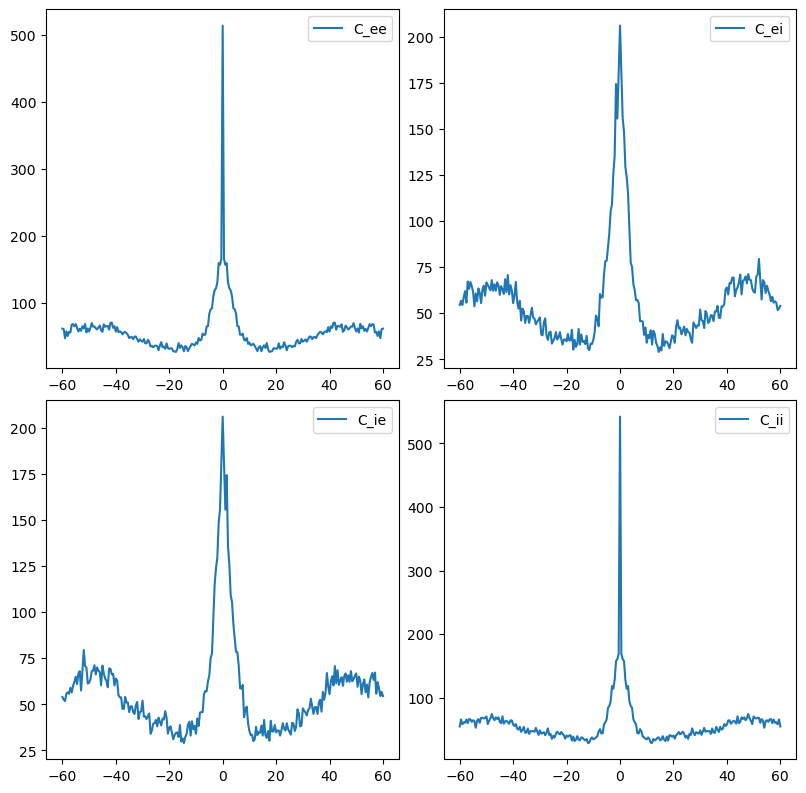

In [25]:
average_cc(times, cc, n_rec_corr_ex=n_rec_corr_ex, n_rec_corr_in=n_rec_corr_in)

In [26]:
nest.ResetKernel()
nest.SetKernelStatus({'local_num_threads': 4})
params['g'] = 5
params['eta'] = 0.9
params['J'] = 0.5

n_rec_corr_ex = 100
n_rec_corr_in = 100
t_start = 300.
t_rec_corr = 4000.
tau_max = 60.

network = BrunelNetwork(**params)

network.create()
network.correlomatrix(n_rec_corr_ex=n_rec_corr_ex,
                      n_rec_corr_in=n_rec_corr_in,
                      tau_max=tau_max,
                      t_start=t_start,
                      t_rec_corr=t_rec_corr)

network.simulate(4600.)
times, cc, n_spikes = network.get_correlomatrix()


Sep 05 11:36:06 NodeManager::prepare_nodes [Info]: 
    Preparing 14505 nodes for simulation.

Sep 05 11:36:06 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 14505
    Simulation time (ms): 4600
    Number of OpenMP threads: 4
    Not using MPI

Sep 05 11:36:28 SimulationManager::run [Info]: 
    Simulation finished.


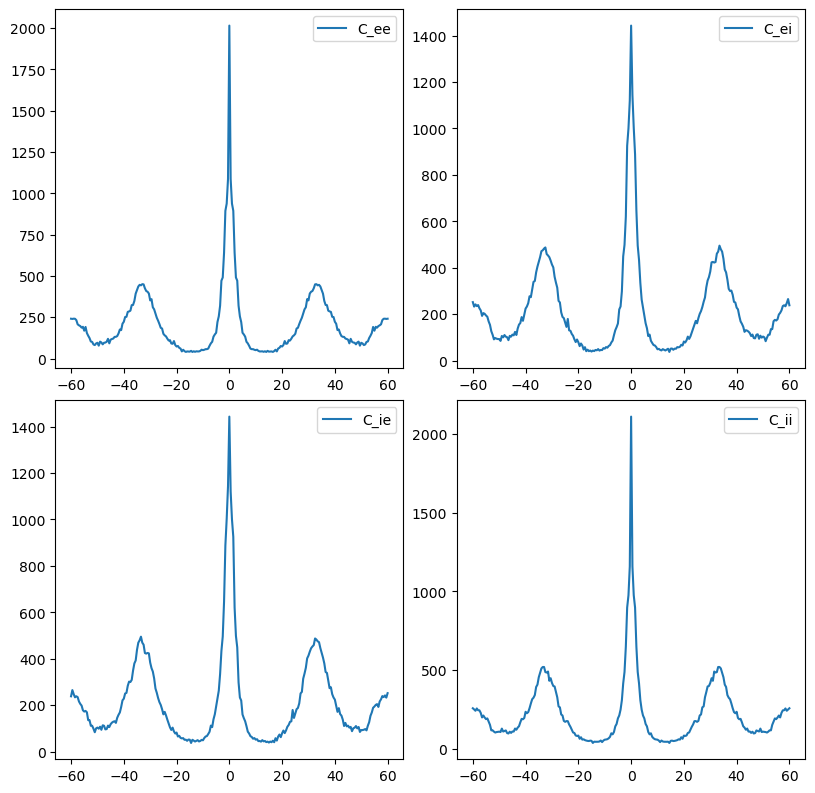

In [27]:
average_cc(times, cc, n_rec_corr_ex=n_rec_corr_ex, n_rec_corr_in=n_rec_corr_in)

# Extensions of the Brunel network
So far, we mostly considered a parameter regime which correspondes to the asynchronous irregular or slow oscillatory behaviour. In his [paper](https://www.nature.com/articles/nn.3658), Ostojic describes a different dynamical state, which can be observed for $g$ and $\eta$ such that the network is in an inhibition dominated regime while increasing the EPSP to values ~ $1\mathrm{mV}$.
How does the spiking behaviour, the rate and the correlation function differ for the classical asynchronous state? What does it imply? For inspiration, you might have a look at Figure 1 of the paper.


Sep 05 11:36:31 NodeManager::prepare_nodes [Info]: 
    Preparing 14504 nodes for simulation.

Sep 05 11:36:32 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 14504
    Simulation time (ms): 820
    Number of OpenMP threads: 4
    Not using MPI

Sep 05 11:36:39 SimulationManager::run [Info]: 
    Simulation finished.
Average firing rate: 30.62 Bq


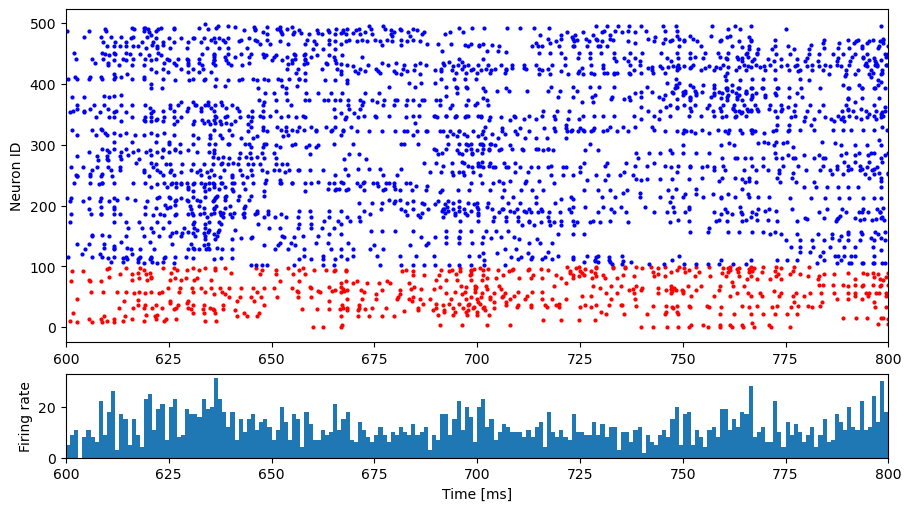

In [28]:
nest.ResetKernel()
nest.SetKernelStatus({'local_num_threads': 4})
params['g'] = 5
params['eta'] = 2
params['J'] = 1.5
params['rec_start'] = 600.
params['rec_stop'] = 800.

network = BrunelNetwork(**params)

network.create()
network.simulate(820.)
spikes_ex, spikes_in = network.get_data()
plot_raster_rate(spikes_ex, spikes_in, params['rec_start'], params['rec_stop'])

In [29]:
nest.ResetKernel()
nest.SetKernelStatus({'local_num_threads': 4})
params['g'] = 5.
params['eta'] = 2.
params['J'] = 1.2
params['rec_start'] = 300.
params['rec_stop'] = 4300.

n_rec_corr_ex = 400
n_rec_corr_in = 400
t_start = 300.
t_rec_corr = 3000.
tau_max = 60.

network.create()
network.correlomatrix(n_rec_corr_ex=n_rec_corr_ex,
                      n_rec_corr_in=n_rec_corr_in,
                      tau_max=tau_max,
                      t_start=t_start,
                      t_rec_corr=t_rec_corr)

network.simulate(3300.)
spikes_ex, spikes_in = network.get_data()
times, cc, n_spikes = network.get_correlomatrix()


Sep 05 11:36:47 NodeManager::prepare_nodes [Info]: 
    Preparing 14505 nodes for simulation.

Sep 05 11:36:47 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 14505
    Simulation time (ms): 3300
    Number of OpenMP threads: 4
    Not using MPI

Sep 05 11:37:18 SimulationManager::run [Info]: 
    Simulation finished.
